In [ ]:
import cv2

In [ ]:
from darkflow.net.build import TFNet

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
%config InlineBackend.figure_format = 'svg'

In [ ]:
options = {
    'model': "cfg/tiny-yolo-voc-1c.cfg",
    'load': 1000,
    'threshold': 0.6
}

tfNet = TFNet(options)

In [ ]:
img = cv2.imread('demo2.jpg', cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB )

In [57]:
result = tfNet.return_predict(img)
result

[{'label': 'Pothole',
  'confidence': 0.102126874,
  'topleft': {'x': 94, 'y': 107},
  'bottomright': {'x': 188, 'y': 145}},
 {'label': 'Pothole',
  'confidence': 0.1470562,
  'topleft': {'x': 49, 'y': 106},
  'bottomright': {'x': 237, 'y': 170}},
 {'label': 'Pothole',
  'confidence': 0.115238294,
  'topleft': {'x': 172, 'y': 110},
  'bottomright': {'x': 343, 'y': 166}},
 {'label': 'Pothole',
  'confidence': 0.121231176,
  'topleft': {'x': 61, 'y': 143},
  'bottomright': {'x': 224, 'y': 207}},
 {'label': 'Pothole',
  'confidence': 0.20959628,
  'topleft': {'x': 167, 'y': 150},
  'bottomright': {'x': 342, 'y': 201}},
 {'label': 'Pothole',
  'confidence': 0.10555748,
  'topleft': {'x': 267, 'y': 150},
  'bottomright': {'x': 353, 'y': 177}},
 {'label': 'Pothole',
  'confidence': 0.13970935,
  'topleft': {'x': 244, 'y': 199},
  'bottomright': {'x': 492, 'y': 307}},
 {'label': 'Pothole',
  'confidence': 0.14256592,
  'topleft': {'x': 171, 'y': 186},
  'bottomright': {'x': 670, 'y': 468}}]

In [58]:
top_left = [(result[i]['topleft']['x'],result[i]['topleft']['y']) for i in range(len(result))]
top_left

[(94, 107),
 (49, 106),
 (172, 110),
 (61, 143),
 (167, 150),
 (267, 150),
 (244, 199),
 (171, 186)]

In [59]:
bottom_right = [(result[i]['bottomright']['x'],result[i]['bottomright']['y']) for i in range(len(result))]
bottom_right

[(188, 145),
 (237, 170),
 (343, 166),
 (224, 207),
 (342, 201),
 (353, 177),
 (492, 307),
 (670, 468)]

In [60]:
labels = [result[i]['label'] for i in range(len(result))]

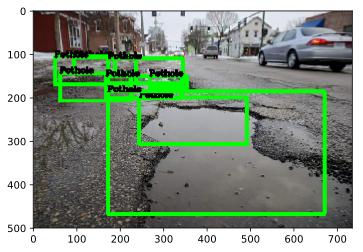

In [61]:
for i in range(len(top_left)):
    img = cv2.rectangle(img, top_left[i], bottom_right[i], (0, 255, 0), 7)
    img = cv2.putText(img, labels[i], top_left[i], cv2.FONT_HERSHEY_COMPLEX, 0.6, (0, 0, 0), 4)
plt.imshow(img)
plt.show()

In [12]:
# Now processing video in real time

In [13]:
import numpy as np
import time

In [14]:
options = {
    'model': "cfg/yolo.cfg",
    'load': "bin/yolov2.weights",
    'threshold': 0.4
}

tfNet = TFNet(options)

Parsing cfg/yolo.cfg
Loading bin/yolov2.weights ...
Successfully identified 203934260 bytes
Finished in 0.02119302749633789s
Model has a coco model name, loading coco labels.

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 608, 608, 3)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 608, 608, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 304, 304, 32)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 304, 304, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 152, 152, 64)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load  |  Yep!  | conv 1x1p0_1  +bnorm  leaky      | (?, 152, 152, 64)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 76, 76, 128)
 Load  |  Yep!  | conv 3x3p1_1  +bn

In [15]:
'''
This file removes frames from a videofile.
The resulting file will look faster when played back at normal speed.
The idea is to create video that can be processed by yolo and look normal speed 
'''

# import cv2
# import numpy as np

capture = cv2.VideoCapture('demo.mp4')
size = (
    int(capture.get(cv2.CAP_PROP_FRAME_WIDTH)),
    int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
)
codec = cv2.VideoWriter_fourcc(*'DIVX')
output = cv2.VideoWriter('reduced_frame_demo.avi', codec, 60.0, size)

i = 0
frame_rate_divider = 3
while(capture.isOpened()):
    ret, frame = capture.read()
    if ret:
        if i % frame_rate_divider == 0:
            # frame = cv2.resize(frame, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_CUBIC)
            output.write(frame)
            cv2.imshow('frame', frame)
            i += 1
        else:
            i += 1
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break

capture.release()
output.release()
cv2.destroyAllWindows()

In [1]:
# Processing a video for YOLO

In [2]:
'''
Here we are processing the reduced_frame_video
and using it for YOLO for every frame and hence 
we can use the seperate frames to form a video 
by combining all these frames
'''

import cv2
from darkflow.net.build import TFNet
import numpy as np
import time

option = {
    'model': 'cfg/yolo.cfg',
    'load': 'bin/yolov2.weights',
    'threshold': 0.30
}

tfnet = TFNet(option)

capture = cv2.VideoCapture('reduced_frame_demo.avi')
colors = [tuple(255 * np.random.rand(3)) for i in range(5)]

while (capture.isOpened()):
    stime = time.time()
    ret, frame = capture.read()
    if ret:
        results = tfnet.return_predict(frame)
        for color, result in zip(colors, results):
            tl = (result['topleft']['x'], result['topleft']['y'])
            br = (result['bottomright']['x'], result['bottomright']['y'])
            label = result['label']
            frame = cv2.rectangle(frame, tl, br, color, 7)
            frame = cv2.putText(frame, label, tl, cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 0), 2)
        cv2.imshow('frame', frame)
        print('FPS {:.1f}'.format(1 / (time.time() - stime)))
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        capture.release()
        cv2.destroyAllWindows()
        break

/opt/anaconda3/envs/pothole_detection/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/pothole_detection/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/pothole_detection/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/pothole_detection






Parsing cfg/yolo.cfg
Loading bin/yolov2.weights ...
Successfully identified 203934260 bytes
Finished in 0.03949904441833496s
Model has a coco model name, loading coco labels.

Building net ...

Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------



       |        | input                            | (?, 608, 608, 3)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 608, 608, 32)

 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 304, 304, 32)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 304, 304, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 152, 152, 64)


/Users/leoadlakha/Desktop/Pothole_Detection/darkflow-master/darkflow/dark/darknet.py:54: UserWarning: ./cfg/yolov2.cfg not found, use cfg/yolo.cfg instead
  cfg_path, FLAGS.model))


 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load  |  Yep!  | conv 1x1p0_1  +bnorm  leaky      | (?, 152, 152, 64)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 76, 76, 128)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 76, 76, 256)
 Load  |  Yep!  | conv 1x1p0_1  +bnorm  leaky      | (?, 76, 76, 128)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 76, 76, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 38, 38, 256)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 38, 38, 512)
 Load  |  Yep!  | conv 1x1p0_1  +bnorm  leaky      | (?, 38, 38, 256)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 38, 38, 512)
 Load  |  Yep!  | conv 1x1p0_1  +bnorm  leaky      | (?, 38, 38, 256)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 38, 38, 512)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 19, 19, 512)
 Load  |  Yep! 

KeyboardInterrupt: 